<a href="https://colab.research.google.com/github/lhalgryn/Stein-Variational-Gradient-Descent/blob/master/SVPG_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For classic control problems
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.5 MB/s eta 0:00:00


In [ ]:
# for LunarLander
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch
import gymnasium as gym
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
from torch import autograd
from scipy.spatial.distance import squareform, pdist
from functools import partial
import math

# Algorithms

## Class to implement NN policy

In [3]:
class Policy(torch.nn.Module):
    """
    Class to implement policy function approximation for SVPG-REINFORCE

    Attributes:
        - input_dim (int): dimension of state space
        - output_dim (int): dimension of action space
        - n_hidden (int): number of neurons for hidden layer
        - log_probs (list): list of log pi(a | s) for actions taken during an episode
        - rewards (list): list of rewards received during an episode

    Methods:
        - forward(state): forward pass of policy network for arg state
        - take_action(state): function to take action and record log_prob of action under policy
        - discount_rewards(gamma): function to discount rewards received during an episode
        - clear(): function to clear the log_probs and rewards lists after end of an episode
        - _flatten_parameters_and_grads(): function to convert parameters and their grads of policy network to a vector.
                                            This is needed to calculate the gram matrix in SVPG.
        - _assign_grads(): function to unflatten and assign the gradients calculated to the corresponding parameters.
                            This is needed because we flattened the parameters using the above method.
    """
    def __init__(self, input_dim, output_dim, n_hidden=128, policy=None):
        super(Policy, self).__init__()
        if policy is None:
            self.policy = nn.Sequential(
                nn.Linear(input_dim, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, output_dim),
                nn.Softmax(dim=-1)
            )
        else:
            self.policy = policy
        # self.policy = nn.Sequential(
        #     nn.Linear(input_dim, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, output_dim),
        #     nn.Softmax(dim=-1)

        # )

        for par in self.policy.parameters():
            par.requires_grad = True
        self.log_probs = []
        self.log_probs_temp = []
        self.rewards_temp = []
        self.rewards = []

    def forward(self, state):
        return self.policy(state)

    def take_action(self, state):
        probs = self.forward(state)
        action_dist = Categorical(probs)
        action = action_dist.sample()
        log_pi = action_dist.log_prob(action)
        self.log_probs_temp.append(log_pi)
        return action.detach().item()

    def discount_rewards(self, gamma):
        discounted_rewards = torch.zeros_like(torch.tensor(self.rewards))
        running_reward = 0
        for t in reversed(range(len(self.rewards))):
            running_reward = running_reward * gamma + self.rewards[t]
            discounted_rewards[t] = running_reward
        mu = torch.mean(discounted_rewards)
        std = torch.std(discounted_rewards)
        discounted_rewards = (discounted_rewards - mu) / (std + 1e-12) # standardize rewards to reduce variance
        return discounted_rewards

    def clear(self, all=False):
        self.log_probs_temp = []
        self.rewards_temp = []
        self.phi = None
        if all:
            self.rewards = []
            self.log_probs = []

    def _flatten_parameters_and_grads(self):
        par_vec = []
        grad_vec = []
        parameters = self.policy.parameters()
        for par in parameters:
            par_vec.append(par.view(-1))
            grad_vec.append(par.grad.detach().view(-1))
        return torch.cat(par_vec), torch.cat(grad_vec)

    def _assign_grads(self, grad_vec):
        counter = 0
        for par in self.policy.parameters():
            n_parameters = torch.prod(torch.LongTensor(list(par.size())))
            par.grad.data = grad_vec[counter:counter+n_parameters].view(par.size())
            counter += n_parameters

    def evaluate_policy(self, n_eval_episodes, max_steps, env_name):
        env = gym.make(env_name)
        total_rewards = []
        for e in tqdm(range(n_eval_episodes)):
            state, _ = env.reset()
            ep_reward = 0
            for t in range(max_steps):
                probs = self.policy(torch.tensor(state, dtype=torch.float32))
                a = torch.argmax(probs)
                new_state, reward, done, trunc, _ = env.step(a.item())
                ep_reward += reward
                state = new_state
                if done or trunc:
                    break
            total_rewards.append(ep_reward)
        return np.mean(total_rewards)


## REINFORCE

In [4]:
class REINFORCE:
    """
    Class to implement REINFORCE-Independent as in https://arxiv.org/abs/1704.02399

    Attributes:
        - gamma (float): discount factor in [0, 1)
        - alpha (float): temperature parameter
        - gym_env_name (string): name of gym environment (e.g., "Cartpole-v1", "MountainCar-v0", "Acrobat-v1")
        - n_particles (int): number of particles (policies) for SVPG
        - max_episodes (int): max number of training episodes #TODO: convergence checks for early stopping
        - max_steps (int): max number of steps in an episode (depends on environment; e.g., 500 for Cartpole-v1)
        - learning_rate (float): initial learning rate for SVPG algorithm (initial because algo uses adaptive step sizes with Adam)
        - best_policy (object of class Policy): policy that yields best evaluation performance
        - num_rollouts (int): number of rollout trajectories to calculate policy gradients

    Methods:
        - _get_gram_matrix_and_grad(X, sigma): function to calculate gram matrix and gradients w.r.t X (particle matrix)
        - _update(): function to implement an SVPG descent step on each particle using the log_probs and rewards history
        - train(): function to train the policies using _update after each episode
        - evaluate_policies(): function to evaluate each of the trained policies and set the best_policy attribute
        - evaluate_ensemble_policy(): function to evaluate naive Bayes ensemble policy
    """

    def __init__(self, gamma, gym_env_name, n_particles, max_episodes, max_steps, learning_rate, n_hidden=128, num_rollouts=1, base_policy=None):
        self.gamma = gamma
        self.n_particles = n_particles
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        self.learning_rate = learning_rate
        self.n_rollouts = num_rollouts
        self.particles = []
        self.optimizers = []
        self.best_policy = None
        self.rewards_per_step = []
        self.rewards_per_episode = []
        self.envs = []
        self.env_name = gym_env_name
        env = gym.make(gym_env_name)
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        for _ in range(self.n_particles):
            self.envs.append(env)
            policy = Policy(input_dim=self.n_states, output_dim=self.n_actions, n_hidden=n_hidden, policy=base_policy)
            optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
            # optimizer = optim.Adagrad(policy.parameters(), lr=learning_rate)
            self.particles.append(policy)
            self.optimizers.append(optimizer)

    def discount_rewards(self, rewards, gamma):
        discounted_rewards = torch.zeros_like(rewards)
        running_reward = 0
        for t in reversed(range(len(rewards))):
            running_reward = running_reward * gamma + rewards[t]
            discounted_rewards[t] = running_reward
        return discounted_rewards

    def train(self):
        total_rewards = []
        eps_completed = []
        avg_reward_per_episode = []
        for e in tqdm(range(self.max_episodes)):
            episode_rewards = []
            for i, env in enumerate(self.envs):
                overall_grad = 0
                for j in range(self.n_rollouts):
                    self.particles[i].clear(all=True)
                    state, _ = env.reset(seed=i*e) # same seed in each rollout, but different in each episode of training
                    for t in range(self.max_steps):
                        a = self.particles[i].take_action(torch.tensor(state))
                        new_state, reward, done, trunc, _ = env.step(a)
                        self.particles[i].rewards.append(reward)
                        state = new_state
                        if done or trunc:
                            break

                    episode_reward = sum(self.particles[i].rewards)
                    episode_rewards.append(episode_reward)
                    discounted_rewards = self.particles[i].discount_rewards(self.gamma)
                    policy_grad = []
                    for log_pi, r in zip(self.particles[i].log_probs_temp, discounted_rewards):
                        policy_grad.append(log_pi * r)
                    overall_grad += sum(policy_grad)

                self.optimizers[i].zero_grad()
                loss = - overall_grad / self.n_rollouts
                loss.backward()
                self.optimizers[i].step()
                self.particles[i].clear(all=True)
            avg_reward_per_episode.append(np.mean(episode_rewards))

        return avg_reward_per_episode


    def evaluate_policies(self, n_eval_episodes, max_steps):
        best_idx = None
        best_reward = -torch.inf
        average_rewards = []
        for i in tqdm(range(self.n_particles)):
            total_rewards = []
            env = self.envs[i]
            policy = self.particles[i]
            policy.clear(all=True)
            for e in range(n_eval_episodes):
                state, _ = env.reset()
                rewards = []
                for t in range(max_steps):
                    probs = policy(torch.tensor(state, dtype=torch.float32))
                    a = torch.argmax(probs)
                    new_state, reward, done, trunc, _ = env.step(a.item())
                    rewards.append(reward)
                    state = new_state
                    if done or trunc:
                        break
                total_rewards.append(np.sum(rewards))
            agent_reward = np.mean(total_rewards)
            average_rewards.append(agent_reward)
            if agent_reward > best_reward:
                best_reward = agent_reward
                best_idx = i
        self.best_policy = self.particles[best_idx]
        return average_rewards

    def evaluate_ensemble_policy(self, eval_episodes):
        test_env = gym.make(self.env_name)
        rewards = []
        episode_rewards = []
        for e in tqdm(range(eval_episodes)):
            state, _ = test_env.reset(seed=e)
            for i, env in enumerate(self.envs):
                _, _ = env.reset(seed=e)
            ep_reward = 0
            for t in range(self.max_steps):
                max_probs = []
                max_actions = []
                for i, env in enumerate(self.envs):
                    policy = self.particles[i]
                    probs = policy(torch.tensor(state, dtype=torch.float32))
                    p = torch.max(probs)
                    max_probs.append(p.item())
                    a = torch.argmax(probs)
                    max_actions.append(a.item())
                max_idx = np.argmax(max_probs)
                a = max_actions[max_idx]
                for i, env in enumerate(self.envs):
                    _, _, done, trunc, _ = env.step(a)
                    if done or trunc:
                        _, _ = env.reset()
                new_state, reward, done, trunc, _ = test_env.step(a)
                # rewards.append(reward)
                ep_reward += reward
                state = new_state
                if done or trunc:
                    break
            episode_rewards.append(ep_reward)
        return episode_rewards

## Vanilla SVPG

In [5]:
class SVPG_REINFORCE:
    """
    Class to implement SVPG REINFORCE

    Attributes:
        - gamma (float): discount factor in [0, 1)
        - alpha (float): temperature parameter
        - gym_env_name (string): name of gym environment (e.g., "Cartpole-v1", "MountainCar-v0", "Acrobat-v1")
        - n_particles (int): number of particles (policies) for SVPG
        - max_episodes (int): max number of training episodes #TODO: convergence checks for early stopping
        - max_steps (int): max number of steps in an episode (depends on environment; e.g., 500 for Cartpole-v1)
        - learning_rate (float): initial learning rate for SVPG algorithm (initial because algo uses adaptive step sizes with Adam)
        - best_policy (object of class Policy): policy that yields best evaluation performance

    Methods:
        - _get_gram_matrix_and_grad(X, sigma): function to calculate gram matrix and gradients w.r.t X (particle matrix)
        - _update(): function to implement an SVPG descent step on each particle using the log_probs and rewards history
        - train(): function to train the policies using _update after each episode
        - evaluate_policies(): function to evaluate each of the trained policies and set the best_policy attribute
    """

    def __init__(self, gamma, alpha, gym_env_name, n_particles, max_episodes, max_steps, learning_rate, n_hidden=128, decay=0.99, num_rollouts=1, base_policy=None):
        self.gamma = gamma
        self.alpha = alpha
        self.n_particles = n_particles
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        self.learning_rate = learning_rate
        self.n_rollouts = num_rollouts
        self.logq0 = 1.0 # flat improper prior as used in the SVPG paper
        self.decay = decay # To decay temperature alpha over training episodes
        self.particles = []
        self.optimizers = []
        self.best_policy = None
        self.envs = []
        self.env_name = gym_env_name
        env = gym.make(gym_env_name)
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        for _ in range(self.n_particles):
            self.envs.append(env)
            policy = Policy(input_dim=self.n_states, output_dim=self.n_actions, n_hidden=n_hidden, policy=base_policy)
            optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
            # optimizer = optim.Adagrad(policy.parameters(), lr=learning_rate)
            self.particles.append(policy)
            self.optimizers.append(optimizer)

    def discount_rewards(self, rewards):
        discounted_rewards = torch.zeros_like(torch.tensor(rewards))
        running_reward = 0
        for t in reversed(range(len(rewards))):
            running_reward = running_reward * self.gamma + rewards[t]
            discounted_rewards[t] = running_reward
        mu = torch.mean(discounted_rewards)
        std = torch.std(discounted_rewards)
        discounted_rewards = (discounted_rewards - mu) / (std + 1e-12) # standardize rewards to reduce variance
        return discounted_rewards


    def _get_gram_matrix_and_grad(self, X, sigma=None):
        X_np = X.data.numpy()
        pairwise_distances = squareform(pdist(X_np)) ** 2
        if sigma is None:
            med = np.median(pairwise_distances)
            sigma = np.sqrt(0.5 * med / np.log(self.n_particles + 1))

        pairwise_distances = torch.tensor(pairwise_distances, dtype=torch.float32)
        K = torch.exp(- pairwise_distances / (2 * sigma**2)) # gram matrix
        dK = -K.matmul(X)
        dK_sum = dK.sum(dim=1)
        for i in range(X.shape[1]):
            dK[:, i] = dK[:, i] + X[:, i].matmul(dK_sum)
        dK /= (sigma**2)

        return K, dK

    def _update(self):
        policy_grads = []
        parameters = []
        for i in range(self.n_particles):
            policy = self.particles[i]
            optimizer = self.optimizers[i]
            overall_loss = 0
            for j in range(self.n_rollouts):
                policy_grad = []
                G = self.discount_rewards(policy.rewards[j])
                for log_pi, r in zip(policy.log_probs[j], G):
                    policy_grad.append(log_pi * r)

                policy_loss = sum(policy_grad)
                overall_loss += policy_loss

            optimizer.zero_grad()
            loss = overall_loss / self.n_rollouts
            loss.backward()
            p_vec, g_vec = policy._flatten_parameters_and_grads()
            policy_grads.append(g_vec.unsqueeze(0))
            parameters.append(p_vec.unsqueeze(0))

        parameters = torch.cat(parameters)
        K, dK = self._get_gram_matrix_and_grad(parameters)
        policy_grads = (1.0 / self.alpha + self.logq0) * torch.cat(policy_grads)
        grad_logp = torch.mm(K, policy_grads)
        phi = - (grad_logp + dK) / self.n_particles

        for i in range(self.n_particles):
            policy = self.particles[i]
            policy._assign_grads(phi[i])
            self.optimizers[i].step()
            self.particles[i].clear(all=True)

    def train(self):
        avg_reward_per_episode = []
        for e in tqdm(range(self.max_episodes)):
            episode_rewards = []
            for i, env in enumerate(self.envs):
                for j in range(self.n_rollouts):
                    state, _ = env.reset(seed=i*j)
                    self.particles[i].clear()
                    for t in range(self.max_steps):
                        a = self.particles[i].take_action(torch.tensor(state))
                        new_state, reward, done, trunc, _ = env.step(a)
                        self.particles[i].rewards_temp.append(reward)
                        state = new_state
                        if done or trunc:
                            break

                    episode_reward = sum(self.particles[i].rewards_temp)
                    episode_rewards.append(episode_reward)
                    self.particles[i].rewards.append(self.particles[i].rewards_temp)
                    self.particles[i].log_probs.append(self.particles[i].log_probs_temp)
            avg_reward_per_episode.append(np.mean(episode_rewards))
            self._update()
            self.alpha *= self.decay

        return avg_reward_per_episode

    def evaluate_policies(self, n_eval_episodes, max_steps):
        best_idx = None
        best_reward = -torch.inf
        average_rewards = []
        for i in tqdm(range(self.n_particles)):
            total_rewards = []
            env = self.envs[i]
            policy = self.particles[i]
            policy.clear()
            for e in range(n_eval_episodes):
                state, _ = env.reset()
                rewards = []
                for t in range(max_steps):
                    probs = policy(torch.tensor(state, dtype=torch.float32))
                    a = torch.argmax(probs)
                    new_state, reward, done, trunc, _ = env.step(a.item())
                    rewards.append(reward)
                    state = new_state
                    if done or trunc:
                        break
                total_rewards.append(np.sum(rewards))
            agent_reward = np.mean(total_rewards)
            average_rewards.append(agent_reward)
            if agent_reward > best_reward:
                best_reward = agent_reward
                best_idx = i
        self.best_policy = self.particles[best_idx]
        return average_rewards


    def evaluate_ensemble_policy(self, eval_episodes):
        test_env = gym.make(self.env_name)
        rewards = []
        episode_rewards = []
        for e in tqdm(range(eval_episodes)):
            state, _ = test_env.reset(seed=e)
            for i, env in enumerate(self.envs):
                _, _ = env.reset(seed=e)
            ep_reward = 0
            for t in range(self.max_steps):
                max_probs = []
                max_actions = []
                for i, env in enumerate(self.envs):
                    policy = self.particles[i]
                    probs = policy(torch.tensor(state, dtype=torch.float32))
                    p = torch.max(probs)
                    max_probs.append(p.item())
                    a = torch.argmax(probs)
                    max_actions.append(a.item())
                max_idx = np.argmax(max_probs)
                a = max_actions[max_idx]
                for i, env in enumerate(self.envs):
                    _, _, done, trunc, _ = env.step(a)
                    if done or trunc:
                        _, _ = env.reset()
                new_state, reward, done, trunc, _ = test_env.step(a)
                # rewards.append(reward)
                ep_reward += reward
                state = new_state
                if done or trunc:
                    break
            episode_rewards.append(ep_reward)
        return episode_rewards

## MK-SVPG

In [6]:
class MK_SVPG_REINFORCE:
    """
    Class to implement SVPG REINFORCE with Multiple Kernels (MK-SVPG)

    Attributes:
        - gamma (float): discount factor in (0, 1)
        - gym_env_name (string): name of gym environment (e.g., "Cartpole-v1", "Acrobat-v1", "LunarLander-v2")
        - n_particles (int): number of particles (policies) for SVPG
        - max_episodes (int): max number of training episodes #TODO: convergence checks for early stopping
        - max_steps (int): max number of steps in an episode (depends on environment; e.g., 500 for Cartpole-v1)
        - learning_rate (float): initial learning rate for SVPG algorithm (initial because algo uses adaptive step sizes with Adam)
        - best_policy (object of class Policy): policy that yields best evaluation performance
        - bandwidth_scales (list): list of scaling factors to median heuristic bandwidth

    Methods:
        - _get_gram_matrix_and_grad(X, sigma): function to calculate gram matrix and gradients w.r.t X (particle matrix)
        - _update(): function to implement an SVPG update step on each particle using the log_probs and rewards history
        - train(): function to train the policies using _update after each episode
        - evaluate_policies(): function to evaluate each of the trained policies and set the best_policy attribute
    """

    def __init__(self, gamma, alpha, gym_env_name, n_particles, max_episodes, decay, max_steps, learning_rate, bandwidth_scales=[0.1, 0.5, 1.0, 1.1, 1.5, 2.0], n_hidden=128, num_rollouts=1, base_policy=None):
        self.gamma = gamma
        self.alpha = alpha
        self.n_particles = n_particles
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        self.learning_rate = learning_rate
        self.bandwidth_scales = bandwidth_scales
        self.n_rollouts = num_rollouts
        self.decay = decay
        self.logq0 = 1.0 # flat improper prior as used in the SVPG paper
        self.particles = []
        self.optimizers = []
        self.best_policy = None
        self.envs = []
        self.env_name = gym_env_name
        env = gym.make(gym_env_name)
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        for _ in range(self.n_particles):
            self.envs.append(env)
            policy = Policy(input_dim=self.n_states, output_dim=self.n_actions, n_hidden=n_hidden, policy=base_policy)
            optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
            # optimizer = optim.Adagrad(policy.parameters(), lr=learning_rate)
            self.particles.append(policy)
            self.optimizers.append(optimizer)

    def discount_rewards(self, rewards):
        discounted_rewards = torch.zeros_like(torch.tensor(rewards))
        running_reward = 0
        for t in reversed(range(len(rewards))):
            running_reward = running_reward * self.gamma + rewards[t]
            discounted_rewards[t] = running_reward
        mu = torch.mean(discounted_rewards)
        std = torch.std(discounted_rewards)
        discounted_rewards = (discounted_rewards - mu) / (std + 1e-12) # standardize rewards to reduce variance
        return discounted_rewards

    def _get_gram_matrix_and_grad(self, X, sigma=None):
        X_np = X.data.numpy()
        pairwise_distances = squareform(pdist(X_np)) ** 2
        if sigma is None:
            med = np.median(pairwise_distances)
            sigma = np.sqrt(0.5 * med / np.log(self.n_particles + 1))

        pairwise_distances = torch.tensor(pairwise_distances, dtype=torch.float32)
        K_list = []
        dK_list = []
        for a in self.bandwidth_scales:
            s = a * sigma ** 2
            K = torch.exp(- pairwise_distances / 2 * s)
            K_list.append(K)
            dK = - K.matmul(X)
            dK_sum = dK.sum(dim=1)
            for i in range(X.shape[1]):
                dK[:, i] = dK[:, i] + X[:, i].matmul(dK_sum)
            dK /= (sigma**2)
            dK_list.append(dK)

        return K_list, dK_list

    def _update(self):
        policy_grads = []
        parameters = []
        for i in range(self.n_particles):
            policy = self.particles[i]
            optimizer = self.optimizers[i]
            overall_loss = 0
            for j in range(self.n_rollouts):
                policy_grad = []
                G = self.discount_rewards(policy.rewards[j])
                for log_pi, r in zip(policy.log_probs[j], G):
                    policy_grad.append(log_pi * r)
                policy_loss = sum(policy_grad)
                overall_loss += policy_loss
            optimizer.zero_grad()
            loss = overall_loss / self.n_rollouts
            loss.backward()
            p_vec, g_vec = policy._flatten_parameters_and_grads()
            policy_grads.append(g_vec.unsqueeze(0))
            parameters.append(p_vec.unsqueeze(0))
        parameters = torch.cat(parameters)

        K_list, dK_list = self._get_gram_matrix_and_grad(parameters)
        phi_list = []
        phi_norms = []
        a = 1 / self.alpha + self.logq0
        for i in range(len(K_list)):
            temp = policy_grads.copy()
            K = K_list[i]
            dK = dK_list[i]
            temp = a * torch.cat(temp)
            grad_logp = torch.mm(K, temp)
            phi = - (grad_logp + dK) / self.n_particles
            phi_list.append(phi)
            phi_norms.append(torch.linalg.norm(phi))

        phi_norm_sum = sum(phi_norms)
        phi = 0
        for i in range(len(phi_list)):
            w = phi_norms[i] / phi_norm_sum
            phi += w * phi_list[i]

        for i in range(self.n_particles):
            policy = self.particles[i]
            policy._assign_grads(phi[i])
            self.optimizers[i].step()
            self.particles[i].clear(all=True)


    def train(self):
        avg_reward_per_episode = []
        for e in tqdm(range(self.max_episodes)):
            episode_rewards = []
            for i, env in enumerate(self.envs):
                rewards = []
                for j in range(self.n_rollouts):
                    state, _ = env.reset(seed=i*j)
                    self.particles[i].clear()
                    for t in range(self.max_steps):
                        a = self.particles[i].take_action(torch.tensor(state))
                        new_state, reward, done, trunc, _ = env.step(a)
                        self.particles[i].rewards_temp.append(reward)
                        state = new_state
                        if done or trunc:
                            break
                    self.particles[i].rewards.append(self.particles[i].rewards_temp)
                    self.particles[i].log_probs.append(self.particles[i].log_probs_temp)
                    episode_reward = sum(self.particles[i].rewards_temp)
                    episode_rewards.append(episode_reward)
            avg_reward_per_episode.append(np.mean(episode_rewards))
            self._update()
            self.alpha *= self.decay
        return avg_reward_per_episode

    def evaluate_policies(self, n_eval_episodes, max_steps, save_path):
        best_idx = None
        best_reward = -torch.inf
        average_rewards = []
        for i in tqdm(range(self.n_particles)):
            total_rewards = []
            env = self.envs[i]
            policy = self.particles[i]
            policy.clear()
            # policy_save_path = os.path.join(save_path, "mk_svpg_best.pt")
            for e in range(n_eval_episodes):
                state, _ = env.reset()
                rewards = []
                for t in range(max_steps):
                    probs = policy(torch.tensor(state, dtype=torch.float32))
                    a = torch.argmax(probs)
                    new_state, reward, done, trunc, _ = env.step(a.item())
                    rewards.append(reward)
                    state = new_state
                    if done or trunc:
                        break
                total_rewards.append(np.sum(rewards))
            agent_reward = np.mean(total_rewards)
            average_rewards.append(agent_reward)
            if agent_reward > best_reward:
                best_reward = agent_reward
                best_idx = i
        self.best_policy = self.particles[best_idx]
        # torch.save(self.best_policy.state_dict(), policy_save_path)
        return average_rewards

    def evaluate_ensemble_policy(self, eval_episodes):
        test_env = gym.make(self.env_name)
        episode_rewards = []
        for e in tqdm(range(eval_episodes)):
            state, _ = test_env.reset(seed=e)
            for i, env in enumerate(self.envs):
                _, _ = env.reset(seed=e)
            ep_reward = 0
            for t in range(self.max_steps):
                max_probs = []
                max_actions = []
                for i, env in enumerate(self.envs):
                    policy = self.particles[i]
                    probs = policy(torch.tensor(state, dtype=torch.float32))
                    p = torch.max(probs)
                    max_probs.append(p.item())
                    a = torch.argmax(probs)
                    max_actions.append(a.item())
                max_idx = np.argmax(max_probs)
                a = max_actions[max_idx]
                for i, env in enumerate(self.envs):
                    _, _, done, trunc, _ = env.step(a)
                    if done or trunc:
                        _, _ = env.reset()
                new_state, reward, done, trunc, _ = test_env.step(a)
                ep_reward += reward
                state = new_state
                if done or trunc:
                    break
            episode_rewards.append(ep_reward)
        return episode_rewards


# Experiments

## CartPole-v1

Results for CartPole:

\begin{array}{|c|c|c|c|}
\text{Algorithm} & \text{Avg over agents} & \text{Ensemble} & \text{best agent}\\
\hline
\text{REINFORCE} & 476.506875 & 500.0 & 500.0\\
\text{MK-SVPG} & 415.22875 & 500.0 & 500.0\\
\text{SVPG} & 473.168125 & 500 & 500
\end{array}

### REINFORCE

In [ ]:
ENV_NAME = "CartPole-v1"
N_PARTICLES = 16
MAX_EPISODES = 50
MAX_STEPS = 500
# LEARNING_RATE = 1e-3
LEARNING_RATE = 1e-2
N_ROLLOUTS = 20
GAMMA = 0.99

N_HIDDEN = 128


reinforce = REINFORCE(gamma=GAMMA, gym_env_name=ENV_NAME, n_particles = N_PARTICLES,
                      max_episodes=MAX_EPISODES, max_steps=MAX_STEPS,
                      learning_rate=LEARNING_RATE, num_rollouts=N_ROLLOUTS)
reinforce_rewards = reinforce.train()


100%|██████████| 50/50 [1:07:09<00:00, 80.60s/it] 


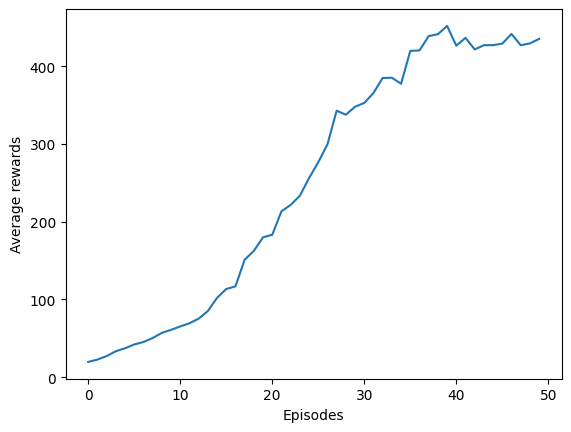

In [ ]:
plt.plot(reinforce_rewards)
plt.ylabel("Average rewards")
plt.xlabel("Episodes")
# plt.savefig("/content/drive/MyDrive/MSc MLAI/Research/PROJECT/REPORT/images/reinforce_cartpole.pdf", dpi=300)
plt.show()

In [ ]:
EVAL_EPISODES = 100
agent_rewards = reinforce.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

100%|██████████| 16/16 [02:00<00:00,  7.51s/it]

[293.5, 496.72, 500.0, 500.0, 500.0, 500.0, 497.82, 497.03, 426.24, 495.96, 490.01, 500.0, 490.78, 500.0, 500.0, 500.0]
480.50375


In [ ]:
reinforce.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)

100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


500.0

In [ ]:
ep_rewards = reinforce.evaluate_ensemble_policy(eval_episodes=100)
print(np.mean(ep_rewards))

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]

500.0


### Vanilla SVPG

In [ ]:
ENV_NAME = "CartPole-v1"
N_PARTICLES = 16
MAX_EPISODES = 50
MAX_STEPS = 500
# LEARNING_RATE = 1e-3
LEARNING_RATE = 1e-2
N_ROLLOUTS = 20
GAMMA = 0.99
ALPHA = 10
N_HIDDEN = 128
DECAY = 1 - 20 / MAX_EPISODES

svpg = SVPG_REINFORCE(gamma=GAMMA, alpha=ALPHA, n_particles=N_PARTICLES, gym_env_name=ENV_NAME, n_hidden=N_HIDDEN,
                        learning_rate=LEARNING_RATE, max_episodes=MAX_EPISODES, max_steps=MAX_STEPS, decay=DECAY, num_rollouts=N_ROLLOUTS)

svpg_rewards = svpg.train()

In [ ]:
plt.plot(svpg_rewards)
plt.ylabel("Average rewards")
plt.xlabel("Episodes")
# plt.savefig("/content/drive/MyDrive/MSc MLAI/Research/PROJECT/REPORT/images/reinforce_cartpole.pdf", dpi=300)
plt.show()

In [ ]:
EVAL_EPISODES = 100
agent_rewards = svpg.evaluate_policies(n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

In [ ]:
svpg.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)

In [ ]:
ep_rewards = svpg.evaluate_ensemble_policy(eval_episodes=100)
print(np.mean(ep_rewards))

### MK-SVPG

In [ ]:
ENV_NAME = "CartPole-v1"
# ENV_NAME = "Acrobot-v1"
N_PARTICLES = 16
MAX_EPISODES = 50
MAX_STEPS = 500
# LEARNING_RATE = 1e-3
LEARNING_RATE = 1e-2
N_ROLLOUTS = 20
GAMMA = 0.99
ALPHA = 10.0
# ALPHA = 5.0
N_HIDDEN = 128
DECAY = 1 - 20 / MAX_EPISODES
B_SCALES = [0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0, 2.5, 3.0]

mk_svpg = MK_SVPG_REINFORCE(gamma=GAMMA, alpha=ALPHA, n_particles=N_PARTICLES, gym_env_name=ENV_NAME, n_hidden=N_HIDDEN,
                            learning_rate=LEARNING_RATE, max_episodes=MAX_EPISODES, max_steps=MAX_STEPS,
                            bandwidth_scales=B_SCALES, num_rollouts=N_ROLLOUTS, decay=DECAY)

mk_svpg_rewards = mk_svpg.train()

In [ ]:
plt.plot(mk_svpg_rewards)
plt.ylabel("Average rewards")
plt.xlabel("Episodes")
plt.show()

In [ ]:
EVAL_EPISODES = 100
agent_rewards = mk_svpg.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

In [ ]:
mk_svpg.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)

In [ ]:
ep_rewards = mk_svpg.evaluate_ensemble_policy(eval_episodes=100)
print(np.mean(ep_rewards))

## Acrobot-v1

ACrobot results:

\begin{array}{|c|c|c|c|}
\text{Algorithm} & \text{Avg} & \text{Best} & \text{ensemble}\\
\hline
\text{MK-SVPG} & -291.70562500000005 & -79.12 & -86.23\\
\text{REINFORCE} & -320.379375 & -81.05 & -500.0\\
\text{SVPG} & -196.61625000000004 &-84.47 & -455.73
\end{array}


### REINFORCE

In [ ]:
ENV_NAME = "Acrobot-v1"
N_PARTICLES = 16
MAX_EPISODES = 100
MAX_STEPS = 500
LEARNING_RATE = 1e-3
# LEARNING_RATE = 1e-2
N_ROLLOUTS = 5
GAMMA = 0.99

N_HIDDEN = 128

reinforce = REINFORCE(gamma=GAMMA, gym_env_name=ENV_NAME, n_particles = N_PARTICLES,
                      max_episodes=MAX_EPISODES, max_steps=MAX_STEPS,
                      learning_rate=LEARNING_RATE, num_rollouts=N_ROLLOUTS)
reinforce_rewards = reinforce.train()

100%|██████████| 100/100 [1:03:54<00:00, 38.35s/it]


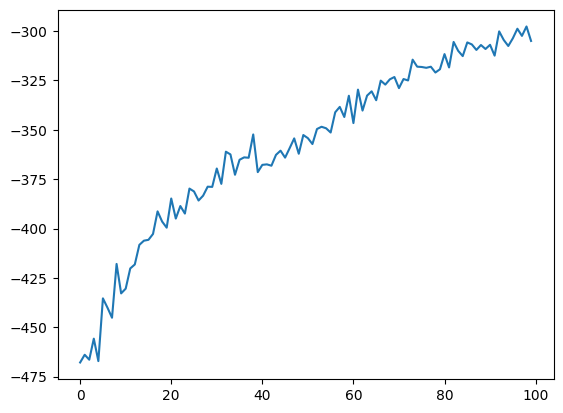

In [ ]:
plt.plot(reinforce_rewards)

In [ ]:
save_path = "/content/drive/MyDrive/MSc MLAI/Research/temp"
import pickle

# Save the list to a file
with open(os.path.join(save_path, "reinforce_rewards"), 'wb') as file:
    pickle.dump(reinforce_rewards, file)


In [ ]:
EVAL_EPISODES = 100
agent_rewards = reinforce.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

100%|██████████| 16/16 [03:15<00:00, 12.24s/it]

[-500.0, -500.0, -376.75, -133.93, -134.81, -500.0, -500.0, -500.0, -99.58, -492.13, -500.0, -107.45, -88.34, -500.0, -104.03, -89.05]
-320.379375


In [ ]:
reinforce.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)

100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


-81.05

In [ ]:
ep_rewards = reinforce.evaluate_ensemble_policy(eval_episodes=100)
np.mean(ep_rewards)

100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


-500.0

### Vanilla SVPG

In [ ]:
ENV_NAME = "Acrobot-v1"
N_PARTICLES = 16
MAX_EPISODES = 100
MAX_STEPS = 500
LEARNING_RATE = 1e-3
# LEARNING_RATE = 1e-2
N_ROLLOUTS = 5
GAMMA = 0.99
ALPHA = 10
N_HIDDEN = 128
DECAY = 1 - 25 / MAX_EPISODES

svpg = SVPG_REINFORCE(gamma=GAMMA, alpha=ALPHA, n_particles=N_PARTICLES, gym_env_name=ENV_NAME, n_hidden=N_HIDDEN,
                        learning_rate=LEARNING_RATE, max_episodes=MAX_EPISODES, max_steps=MAX_STEPS, decay=DECAY, num_rollouts=N_ROLLOUTS)

svpg_rewards = svpg.train()

100%|██████████| 100/100 [49:04<00:00, 29.44s/it]


In [ ]:
save_path = "/content/drive/MyDrive/MSc MLAI/Research/temp"
import pickle
import os
# Save the list to a file
with open(os.path.join(save_path, "svpg_rewards"), 'wb') as file:
    pickle.dump(svpg_rewards, file)

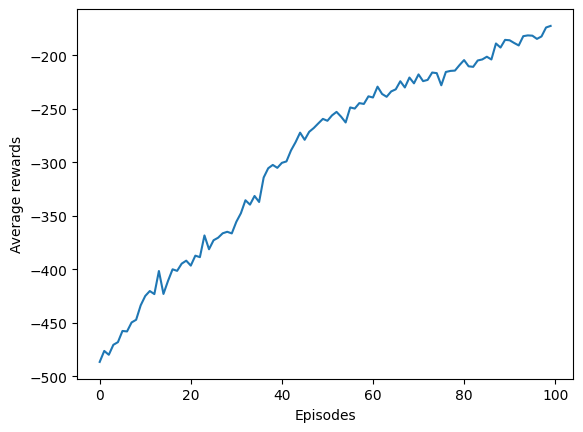

In [ ]:
plt.plot(svpg_rewards)
plt.ylabel("Average rewards")
plt.xlabel("Episodes")
plt.show()

In [ ]:
EVAL_EPISODES = 100
agent_rewards = svpg.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

100%|██████████| 16/16 [01:53<00:00,  7.09s/it]

[-90.01, -496.42, -99.9, -84.05, -139.53, -500.0, -87.37, -95.42, -89.93, -500.0, -97.34, -303.64, -229.7, -156.2, -84.88, -91.47]
-196.61625000000004


In [ ]:
ep_rewards = svpg.evaluate_ensemble_policy(eval_episodes=100)
np.mean(ep_rewards)

100%|██████████| 100/100 [03:48<00:00,  2.29s/it]


-455.73

In [ ]:
svpg.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=100, max_steps=MAX_STEPS)

100%|██████████| 100/100 [00:04<00:00, 24.50it/s]


-84.47

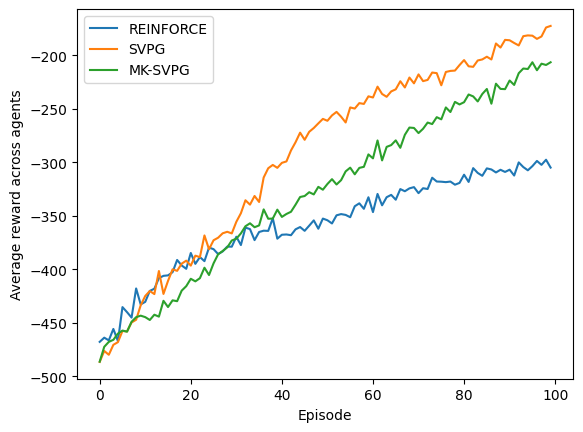

In [ ]:
plt.plot(reinforce_rewards, label="REINFORCE")
plt.plot(svpg_rewards, label="SVPG")
plt.plot(mk_svpg_rewards, label="MK-SVPG")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Average reward across agents")
# plt.savefig("/content/drive/MyDrive/MSc MLAI/Research/PROJECT/REPORT/images/acrobot.pdf", dpi=300)
plt.show()

### MK-SVPG

In [ ]:
"""
BEST
# v3
[-500.0, -414.3, -500.0, -177.67, -248.15, -103.89, -82.64, -113.04, -500.0, -324.15, -110.93, -132.88, -87.9, -500.0, -489.74, -382.0]
avg: -291.70562500000005
best: -79.12
ensemble: -86.23
"""
ENV_NAME = "Acrobot-v1"
N_PARTICLES = 16
MAX_EPISODES = 100
MAX_STEPS = 500
LEARNING_RATE = 1e-3
# LEARNING_RATE = 1e-2
N_ROLLOUTS = 5
GAMMA = 0.99
ALPHA = 10
N_HIDDEN = 128
DECAY = 1 - 25 / MAX_EPISODES

B_SCALES = [0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0, 2.5, 3.0, 4.0, 5.0]

mk_svpg = MK_SVPG_REINFORCE(gamma=GAMMA, alpha=ALPHA, n_particles=N_PARTICLES, gym_env_name=ENV_NAME, n_hidden=N_HIDDEN,
                            learning_rate=LEARNING_RATE, max_episodes=MAX_EPISODES, max_steps=MAX_STEPS,
                            bandwidth_scales=B_SCALES, num_rollouts=N_ROLLOUTS, decay=DECAY)

mk_svpg_rewards = mk_svpg.train()

100%|██████████| 100/100 [54:27<00:00, 32.68s/it]


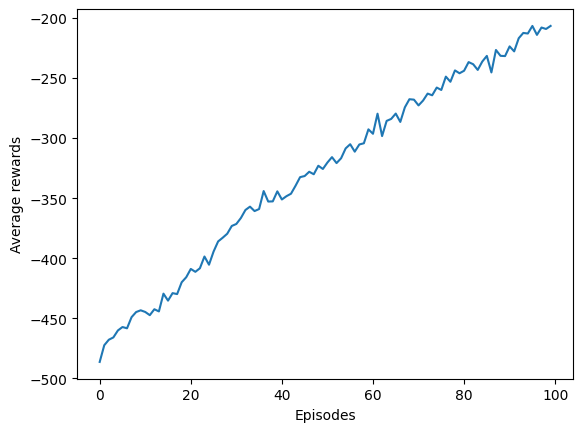

In [ ]:
plt.plot(mk_svpg_rewards)
plt.ylabel("Average rewards")
plt.xlabel("Episodes")
plt.show()

In [ ]:
EVAL_EPISODES = 100
agent_rewards = mk_svpg.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

100%|██████████| 16/16 [02:42<00:00, 10.14s/it]

[-500.0, -414.3, -500.0, -177.67, -248.15, -103.89, -82.64, -113.04, -500.0, -324.15, -110.93, -132.88, -87.9, -500.0, -489.74, -382.0]
-291.70562500000005


In [ ]:
ep_rewards = mk_svpg.evaluate_ensemble_policy(eval_episodes=100)
np.mean(ep_rewards)

100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


-86.23

In [ ]:
mk_svpg.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=100, max_steps=MAX_STEPS)

100%|██████████| 100/100 [00:03<00:00, 32.09it/s]


-79.12

## LunarLander

LunarLander results:

\begin{array}{|c|c|c|c|}
\text{Algorithm} & \text{Avg} & \text{Best} & \text{Ensemble}\\
\hline
\text{REINFORCE} & -45.93956015666633 & 80.70038810024803 & -27.702749402440677\\
\text{MK-SVPG} & 97.7318679805551 & 247.79730205915243 & 241.0325609803155\\
\text{SVPG} & 182.78145238287806 & 250.50197375790623 & 231.4279477060706
\end{array}


### REINFORCE

In [ ]:
ENV_NAME = "LunarLander-v2"
N_PARTICLES = 16
MAX_EPISODES = 500
MAX_STEPS = 1000
LEARNING_RATE = 1e-3
N_ROLLOUTS = 10
GAMMA = 0.99

N_HIDDEN = 128

reinforce = REINFORCE(gamma=GAMMA, gym_env_name=ENV_NAME, n_particles = N_PARTICLES,
                      max_episodes=MAX_EPISODES, max_steps=MAX_STEPS,
                      learning_rate=LEARNING_RATE, num_rollouts=N_ROLLOUTS)
reinforce_rewards = reinforce.train()

In [ ]:
import pickle
import os
save_path = "/content/drive/MyDrive/MSc MLAI/Research/temp"
with open(os.path.join(save_path, "reinforce_lunar.pkl"), "wb") as file:
    pickle.dump(reinforce_rewards, file)

In [ ]:
EVAL_EPISODES = 100
agent_rewards = reinforce.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

In [ ]:
reinforce.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)

In [ ]:
ep_rewards = reinforce.evaluate_ensemble_policy(eval_episodes=EVAL_EPISODES)
print(np.mean(ep_rewards))

### SVPG

In [ ]:
ENV_NAME = "LunarLander-v2"
N_PARTICLES = 16
MAX_EPISODES = 500
MAX_STEPS = 1000
LEARNING_RATE = 1e-3
N_ROLLOUTS = 10
GAMMA = 0.99
ALPHA = 10
N_HIDDEN = 128
DECAY = 1 - 25 / MAX_EPISODES

svpg = SVPG_REINFORCE(gamma=GAMMA, alpha=ALPHA, n_particles=N_PARTICLES, gym_env_name=ENV_NAME, n_hidden=N_HIDDEN,
                        learning_rate=LEARNING_RATE, max_episodes=MAX_EPISODES, max_steps=MAX_STEPS, decay=DECAY, num_rollouts=N_ROLLOUTS)

svpg_rewards = svpg.train()

In [ ]:
import pickle
import os
save_path = "/content/drive/MyDrive/MSc MLAI/Research/temp"
with open(os.path.join(save_path, "svpg_lunar.pkl"), "wb") as file:
    pickle.dump(svpg_rewards, file)
    # temp = pickle.load(file)

In [ ]:
EVAL_EPISODES = 100
agent_rewards = svpg.evaluate_policies(n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

In [ ]:
svpg.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=EVAL_EPISODES, max_steps=MAX_STEPS)

In [ ]:
ep_rewards = svpg.evaluate_ensemble_policy(eval_episodes=100)
print(np.mean(ep_rewards))

### MK-SVPG

In [ ]:
ENV_NAME = "LunarLander-v2"
N_PARTICLES = 16
MAX_EPISODES = 500
MAX_STEPS = 1000
LEARNING_RATE = 1e-3
# LEARNING_RATE = 1e-2
N_ROLLOUTS = 10
GAMMA = 0.99
ALPHA = 10
N_HIDDEN = 128
DECAY = 1 - 25 / MAX_EPISODES

B_SCALES = [0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0, 2.5, 3.0, 4.0, 5.0]

mk_svpg = MK_SVPG_REINFORCE(gamma=GAMMA, alpha=ALPHA, n_particles=N_PARTICLES, gym_env_name=ENV_NAME, n_hidden=N_HIDDEN,
                            learning_rate=LEARNING_RATE, max_episodes=MAX_EPISODES, max_steps=MAX_STEPS,
                            bandwidth_scales=B_SCALES, num_rollouts=N_ROLLOUTS, decay=DECAY)

mk_svpg_rewards = mk_svpg.train()

100%|██████████| 500/500 [11:24:20<00:00, 82.12s/it] 


In [ ]:
import pickle
import os
save_path = "/content/drive/MyDrive/MSc MLAI/Research/temp"
with open(os.path.join(save_path, "mk_svpg_lunar.pkl"), "wb") as file:
    pickle.dump(mk_svpg_rewards, file)

In [ ]:
with open("/content/drive/MyDrive/MSc MLAI/Research/temp/mk_svpg_lunar.pkl", "rb") as file:
    temp = pickle.load(file)

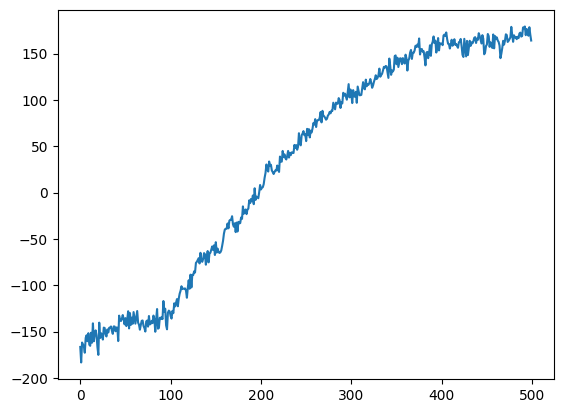

In [ ]:
plt.plot(temp)

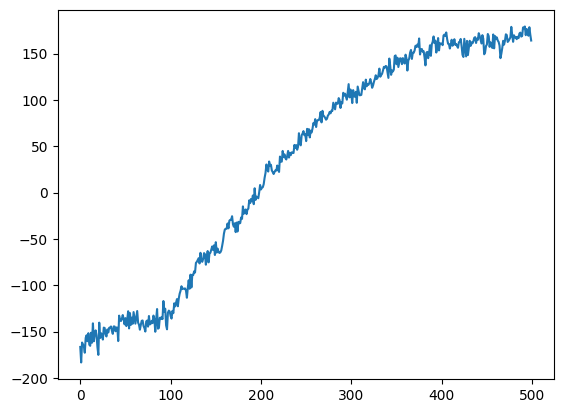

In [ ]:
plt.plot(mk_svpg_rewards)

In [ ]:
EVAL_EPISODES = 100
agent_rewards = mk_svpg.evaluate_policies(EVAL_EPISODES, MAX_STEPS)
print(agent_rewards)
print(np.mean(agent_rewards))

100%|██████████| 16/16 [05:26<00:00, 20.41s/it]

[144.5860396142797, 95.63144495191007, 131.7137766954204, 100.55264985040888, 192.60798870597867, 105.27037488449012, 156.31580140092322, -76.47832513361935, -33.221229576550485, -37.00186543360398, 93.23907544984526, 167.49831602917584, 239.94185498266043, 91.2032509428022, 7.299810257881091, 184.55092406687947]
97.7318679805551


In [ ]:
mk_svpg.best_policy.evaluate_policy(env_name=ENV_NAME, n_eval_episodes=100, max_steps=MAX_STEPS)

100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


247.79730205915243

In [ ]:
ep_rewards = mk_svpg.evaluate_ensemble_policy(eval_episodes=100)
np.mean(ep_rewards)

100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


241.0325609803155

In [ ]:
save_path = "/content/drive/MyDrive/MSc MLAI/Research/PROJECT/SVPG policies/LunarLander/mksvpg"
for i, policy in enumerate(mk_svpg.particles):
    torch.save(policy.policy.state_dict(), os.path.join(save_path, f"mk_svpg_p{i}.pt"))